# Preamble

In [322]:
import os, sys, json

import pandas as pd
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.legend import Legend
from matplotlib.ticker import FuncFormatter

import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier

import lifelines as ll

from sksurv.ensemble import RandomSurvivalForest

import shap

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Global Config

In [3]:
# wow very nice, Jupyter
module_path = os.path.abspath(os.path.join("C:\\Users\\mmk\\PycharmProjects\\ckd"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# put %autoreload at the start of every cell using ckdlib attributes
%load_ext autoreload
# %autoreload 1
%aimport ckdlib.my_seaborn_plots
plib = ckdlib.my_seaborn_plots

%aimport ckdlib.modelling
mlib = ckdlib.modelling

%aimport ckdlib.formulae
flib = ckdlib.formulae

%aimport ckdlib.defs
defs = ckdlib.defs

%aimport ckdlib.utils
ulib = ckdlib.utils

## Global Data

In [5]:
# date of access
# this is used to drop rows that are less than 6 months before the date that the data was downloaded
# this is done because there is no way of knowing what will happen (or has happened) to that patient yet
DOA = pd.to_datetime("05/31/2021")

# study start and end times
SS = pd.to_datetime("01/03/2010")
SE = DOA

# first date in dataset
FY = pd.to_datetime("01/01/2005")

# time-to-endpoint threshold in months
ttes = [6, 12, 24]

DEFAULT_TTE_THRESH = 6 * 30
tte_thresh = DEFAULT_TTE_THRESH

data_file = "../data/data_unified.xlsx"

## Functions

### General

In [6]:
def format_for_sksurv(D):
    cens = D.censor.to_numpy()
    sas = D.sa_time.to_numpy()

    ret = list()

    for i, c in enumerate(cens):
        ret.append((c == 0, sas[i]))

    return np.asarray(ret, dtype=[("status", "?"), ("time", "int")])

### Plotting

In [273]:
def reset_mpl():
    mpl.rcParams.update(mpl.rcParamsDefault)
    
def set_mpl():
    
    font = {
    "family": "Arial",
    "size": 22
    }
    
    plt.rc("font", **font)
    plt.rc("xtick", labelsize=20)
    plt.rc("ytick", labelsize=20)
    plt.rc("axes", labelweight="bold")
    plt.rc("axes", titleweight="bold")

# Preprocessing

In [7]:
df_master = pd.read_excel(data_file, sheet_name=None)["UNIFIED"]

In [8]:
df = df_master.copy()

# number of unique patients (before drop)
df.pt_id.unique().shape

(2432,)

In [9]:
%autoreload

# variables of interest
kfre_o = defs.var_sets[-1] + ["measd_sbp", "measd_dbp", "bmi", "alb", "creat", "pmh_chf", "potassium"]
kfre_o

['calc',
 'phos',
 'pmh_hyper',
 'age',
 'gender',
 'diabetes',
 'egfr_epi_nr',
 'acr',
 'alb',
 'total_co2',
 'measd_sbp',
 'measd_dbp',
 'bmi',
 'alb',
 'creat',
 'pmh_chf',
 'potassium']

In [10]:
# exclusion criteria
df = df.loc[(df.ex_crit == 0)]

# missing predictors
df = df.dropna(subset=kfre_o)

In [11]:
# building 3 datasets labeled for 6, 12, and 24 months respectively
dfs_dict = dict()

for tte in ttes:
    dft = df.copy()
    
    # putting in label; defined as time-to-endpoint <= tte_thresh (6 months)
    dft["label"] = 0

    # inpatient KRT
    # 
    dft.loc[
        ((dft["patransf_where"] == 5) | (dft["patransf_where"] == 6)) & (dft["sa_time_visit"] <= tte * 30), 
        "label"
    ] = 1

    # planned KRT
    dft.loc[
        ((dft["patransf_where"] == 2) | (dft["patransf_where"] == 3) 
         | (dft["patransf_where"] == 4) | (dft["patransf_where"] == 7)) & (dft["sa_time_visit"] <= tte * 30), "label"
    ] = 1
    
    # exclude patients censored by DOA; we cannot say if they need KRT 6/12/24 months away
    # drop entries that are less than 24 months before the date of access and have no tte
    dft = dft.loc[
        ~((dft.patransf_pri == 0) & (dft.cs_pt_alive == 1) & (((DOA - dft.fup_date) / np.timedelta64(1, "D")) < 24 * 30))
    ].reset_index(drop=True)
    
    # printing 
    print(dft["label"].value_counts())
    print(len(dft["pt_id"].unique()))
    
    # splitting for train and holdout test (80, 20); we will take the first fold indices as first data split
    sgkf_tt = StratifiedGroupKFold(n_splits=5)

    train_test_folds = [f for f in sgkf_tt.split(dft.drop(columns=["label"]), dft.label, dft.pt_id)]
    
    dfs_dict["df" + str(tte)] = (dft, dft.loc[train_test_folds[0][0]], dft.loc[train_test_folds[0][1]])

0    9837
1    2800
Name: label, dtype: int64
1918
0    8024
1    4613
Name: label, dtype: int64
1918
1    6797
0    5840
Name: label, dtype: int64
1918


# Cox Model HRs

## Fitting Standalone Cox Models on Entire Dataset

In [ ]:
var_id_order = [
    "age", "gender", "egfr_epi_nr", "acr", "calc", "phos", "total_co2", "alb", 
    "diabetes", "pmh_hyper", "pmh_chf", "potassium", "measd_sbp"
]

var_order = [
    "Age", "Female Sex", "eGFR", "ACR", "Calcium", "Phosphate", "Total CO2", "Albumin", 
    "Diabetes", "Hypertension", "Cardiovascular Disease", "Potassium", "Systolic BP"
]

vs = [
    ["acr", "age", "egfr_epi_nr", "gender"],
    ["acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2", "potassium", "pmh_chf", "measd_sbp"]
]

predictor_sets = ["4V", "8V", "10V", "13V"]

temp = dfs_dict["df6"][0].copy()

hr_bs, hr_tvs = list(), list()
p_bs, p_tvs = list(), list()
ci_bs, ci_tvs = list(), list()

for v in vs:

    hr_b = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    hr_tv = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    p_b = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    p_tv = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    ci_b = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    ci_tv = pd.DataFrame(np.empty(shape=(1, len(v))), columns=v)
    
    inds_b = temp.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)

    data_b = inds_b[v].copy()
    means_b = data_b[v].mean()
    data_b[v] -= means_b

    data_b = pd.concat([data_b, inds_b[["censor", "sa_time"]]], axis=1)
    data_b["censor"] = (data_b.censor == 0).astype(int)

    # time-varying
    data_tv = temp[v].copy()
    means_tv = data_tv[v].mean()
    data_tv[v] -= means_tv

    data_tv = pd.concat([data_tv, temp[["pt_id", "start", "stop", "event"]]], axis=1)

    # don't center categoricals like gender
    for v1 in v:
        if v1 in defs.cat_voi:
            data_b[v1] = inds_b[v1].copy()
            data_tv[v1] = temp[v1].copy()


    # ~~~~~ FITTING ~~~~~ #
    cph_b = ll.CoxPHFitter()
    cph_b.fit(data_b, duration_col="sa_time", event_col="censor")

    cph_tv = ll.CoxTimeVaryingFitter()
    cph_tv.fit(data_tv, id_col="pt_id", event_col="event", start_col="start", stop_col="stop")

    hr_b.iloc[0] = np.round(cph_b.summary["exp(coef)"][v].ravel(), 3)
    hr_tv.iloc[0] = np.round(cph_tv.summary["exp(coef)"][v].ravel(), 3)
    p_b.iloc[0] = np.round(cph_b.summary.p[v].ravel(), 3)
    p_tv.iloc[0] = np.round(cph_tv.summary.p[v].ravel(), 3)

    sb, stv = list(), list()
    lowsb, upsb = cph_b.summary["exp(coef) lower 95%"][v], cph_b.summary["exp(coef) upper 95%"][v]
    lowstv, upstv = cph_tv.summary["exp(coef) lower 95%"][v], cph_tv.summary["exp(coef) upper 95%"][v]

    for c in v:
        sb.append("[{:.3f}, {:.3f}]".format(lowsb[c], upsb[c]))
        stv.append("[{:.3f}, {:.3f}]".format(lowstv[c], upstv[c]))

    ci_b.iloc[0] = np.asarray(sb)
    ci_tv.iloc[0] = np.asarray(stv)

    hr_bs.append(hr_b)
    hr_tvs.append(hr_tv)
    p_bs.append(p_b)
    p_tvs.append(p_tv)
    ci_bs.append(ci_b)
    ci_tvs.append(ci_tv)

## Table S1

In [ ]:
tvt = pd.melt(hr_bs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(hr_bs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

b = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

tvt = pd.melt(ci_bs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(ci_bs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

cib = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

for v in predictor_sets:
    b[v] = b[v].str.cat(" " + cib[v])
b


,4V,8V,10V,13V
Age,"0.974 [0.971, 0.978]","0.976 [0.972, 0.979]","0.974 [0.970, 0.978]","0.972 [0.968, 0.976]"
Female Sex,"0.827 [0.739, 0.926]","0.82 [0.730, 0.921]","0.826 [0.736, 0.928]","0.821 [0.730, 0.922]"
eGFR,"0.888 [0.877, 0.899]","0.898 [0.887, 0.909]","0.896 [0.885, 0.908]","0.895 [0.883, 0.906]"
ACR,"1.001 [1.001, 1.002]","1.001 [1.001, 1.001]","1.001 [1.001, 1.001]","1.001 [1.001, 1.001]"
Calcium,NaN,"0.542 [0.368, 0.799]","0.514 [0.349, 0.758]","0.56 [0.378, 0.831]"
Phosphate,NaN,"1.57 [1.302, 1.892]","1.479 [1.222, 1.789]","1.469 [1.212, 1.780]"
Total CO2,NaN,"0.999 [0.981, 1.018]","0.997 [0.978, 1.016]","0.994 [0.975, 1.013]"
Albumin,NaN,"0.959 [0.947, 0.971]","0.96 [0.948, 0.972]","0.958 [0.946, 0.970]"
Diabetes,NaN,NaN,"1.011 [0.896, 1.140]","0.983 [0.870, 1.110]"
Hypertension,NaN,NaN,"1.56 [1.254, 1.939]","1.49 [1.197, 1.854]"


In [ ]:
tvt = pd.melt(p_bs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(p_bs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

pb = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]
pb

,4V,8V,10V,13V
Age,0.0,0.0,0.0,0.0
Female Sex,0.001,0.001,0.001,0.001
eGFR,0.0,0.0,0.0,0.0
ACR,0.0,0.0,0.0,0.0
Calcium,NaN,0.001,0.001,0.003
Phosphate,NaN,0.0,0.0,0.0
Total CO2,NaN,0.944,0.889,0.645
Albumin,NaN,0.0,0.0,0.0
Diabetes,NaN,NaN,0.983,0.68
Hypertension,NaN,NaN,0.0,0.001


## Table S2

In [ ]:
tvt = pd.melt(hr_tvs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(hr_tvs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

tvv = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

tvt = pd.melt(ci_tvs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(ci_tvs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

citvv = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]

for v in predictor_sets:
    tvv[v] = tvv[v].str.cat(" " + citvv[v])
tvv


,4V,8V,10V,13V
Age,"0.981 [0.977, 0.984]","0.981 [0.977, 0.985]","0.979 [0.976, 0.983]","0.978 [0.974, 0.982]"
Female Sex,"0.735 [0.656, 0.823]","0.751 [0.670, 0.842]","0.757 [0.675, 0.849]","0.762 [0.679, 0.854]"
eGFR,"0.669 [0.657, 0.682]","0.686 [0.672, 0.700]","0.683 [0.669, 0.697]","0.681 [0.666, 0.695]"
ACR,"1.001 [1.001, 1.001]","1.001 [1.001, 1.001]","1.001 [1.000, 1.001]","1.001 [1.000, 1.001]"
Calcium,NaN,"0.659 [0.476, 0.911]","0.65 [0.470, 0.899]","0.666 [0.480, 0.924]"
Phosphate,NaN,"1.557 [1.331, 1.820]","1.512 [1.289, 1.774]","1.49 [1.270, 1.747]"
Total CO2,NaN,"1.019 [1.001, 1.037]","1.015 [0.997, 1.033]","1.012 [0.994, 1.031]"
Albumin,NaN,"0.971 [0.959, 0.982]","0.971 [0.959, 0.983]","0.971 [0.959, 0.982]"
Diabetes,NaN,NaN,"1.172 [1.039, 1.322]","1.102 [0.975, 1.246]"
Hypertension,NaN,NaN,"1.238 [0.995, 1.540]","1.216 [0.977, 1.514]"


In [ ]:
tvt = pd.melt(p_tvs[0], var_name="Predictor", value_name="HR")
tvt["Predictor Set"] = predictor_sets[0]

for tvi, tv in enumerate(p_tvs[1:]):
    newtv = pd.melt(tv, var_name="Predictor", value_name="HR")
    newtv["Predictor Set"] = predictor_sets[tvi + 1]
    
    tvt = pd.concat([tvt, newtv], axis=0)

t = pd.DataFrame(tvt).reset_index(drop=True)

t = t.pivot(index="Predictor", columns=["Predictor Set"]).loc[var_id_order]
tcols = t["HR"].columns.to_numpy()

ptvv = pd.DataFrame(
    t.to_numpy(),
    index=var_order, columns=tcols, dtype=str,
)[predictor_sets]
ptvv

,4V,8V,10V,13V
Age,0.0,0.0,0.0,0.0
Female Sex,0.0,0.0,0.0,0.0
eGFR,0.0,0.0,0.0,0.0
ACR,0.0,0.0,0.0,0.0
Calcium,NaN,0.012,0.009,0.015
Phosphate,NaN,0.0,0.0,0.0
Total CO2,NaN,0.041,0.107,0.192
Albumin,NaN,0.0,0.0,0.0
Diabetes,NaN,NaN,0.01,0.118
Hypertension,NaN,NaN,0.055,0.08


# ML Examination 2 (SHAP Plots)

Explaining the same 1000 random samples.

In [507]:
vs = [
    ["acr", "age", "egfr_epi_nr", "gender"],
    ["acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2"],
    ["diabetes", "pmh_hyper", "acr", "age", "egfr_epi_nr", "gender", "alb", "phos", "calc", "total_co2", "potassium", "pmh_chf", "measd_sbp"]
]

var_id_order = [
    "age", "gender", "egfr_epi_nr", "acr", "calc", "phos", "total_co2", "alb", 
    "diabetes", "pmh_hyper", "pmh_chf", "potassium", "measd_sbp"
]

var_order = [
    "Age", "Female Sex", "eGFR", "ACR", "Calcium", "Phosphate", "Bicarbonate", "Albumin", 
    "Diabetes", "Hypertension", "CHF", "Potassium", "Systolic BP"
]

In [13]:
rng = default_rng()
sample_is = rng.choice(a=dfs_dict["df6"][0].shape[0], size=1000, replace=False)

## Random Forest Classifier

In [14]:
rfc_shap_values = list()

for dfk in dfs_dict.keys():
    temp_rfc_shap_values = list()

    for vi, var_set in enumerate(vs):
        dft = dfs_dict[dfk][0].copy()

        classes_weights = {
            0: len(dft.label) / (2 * dft.label.value_counts()[0]), 
            1: len(dft.label) / (2 * dft.label.value_counts()[1])
        }

        rfc = RandomForestClassifier(
            max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, class_weight=classes_weights, n_jobs=-1
        )
        print("Fitting...", end=""), 
        rfc.fit(dft[var_set], dft.label)

        print("Fitted")
        temp_rfc_shap_values.append((rfc, dft[var_set].iloc[sample_is], dft.label.iloc[sample_is]))
    
    rfc_shap_values.append(temp_rfc_shap_values)

Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted


### Figure S1

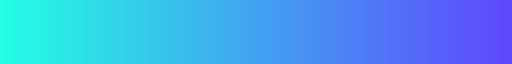

In [ ]:
my_cmap = sns.blend_palette(colors=["#24FFE5", "#6047FF"], n_colors=3, as_cmap=True)
my_cmap

**4V**

In [410]:
%autoreload

fours = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[0]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    fours.append([rfc, explainer, shap_values])

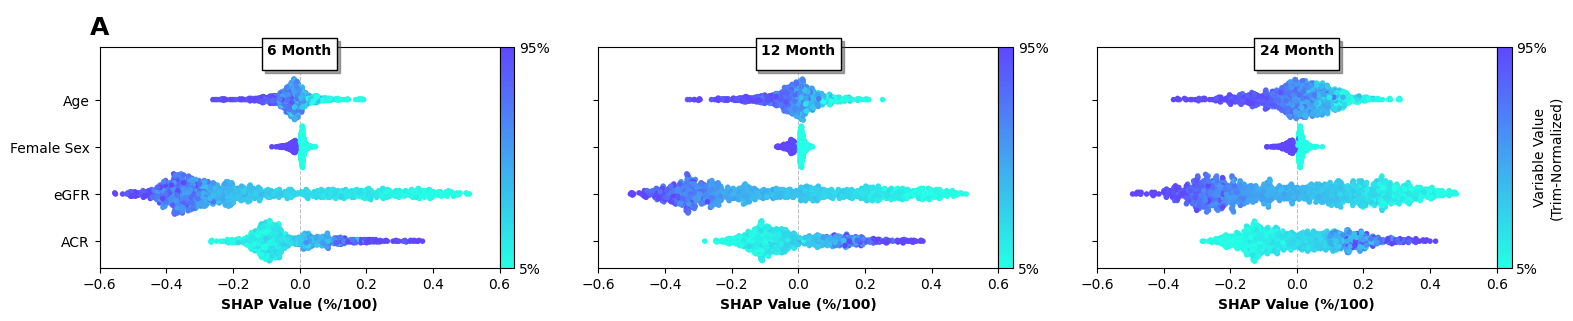

In [464]:
plt.style.use("default")
fig_height = 3

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]

for rfci, (rfc, explainer, shap_values) in enumerate(fours):

    num_feats = shap_values[1].shape[1]

    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-2.85)

    plots[rfci].vlines(
        x=[0], ymin=-2.85, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.07),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.2), title="A", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=15 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)
        
plt.tight_layout()
plt.show()

**8V**

In [ ]:
%autoreload

eights = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[1]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    eights.append([rfc, explainer, shap_values])

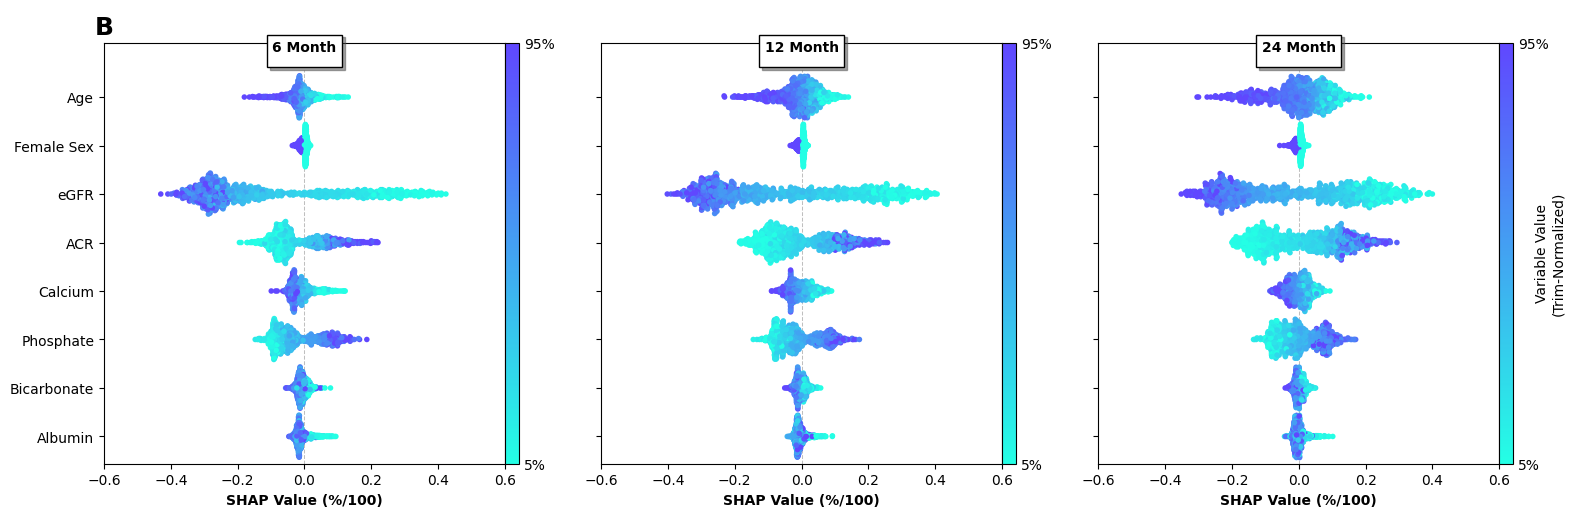

In [480]:
plt.style.use("default")
fig_height = 5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]

for rfci, (rfc, explainer, shap_values) in enumerate(eights):
    num_feats = shap_values[1].shape[1]
    
    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-6.05)

    plots[rfci].vlines(
        x=[0], ymin=-6.05, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.035),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.095), title="B", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**10V**

In [420]:
%autoreload

tens = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[2]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    tens.append([rfc, explainer, shap_values])

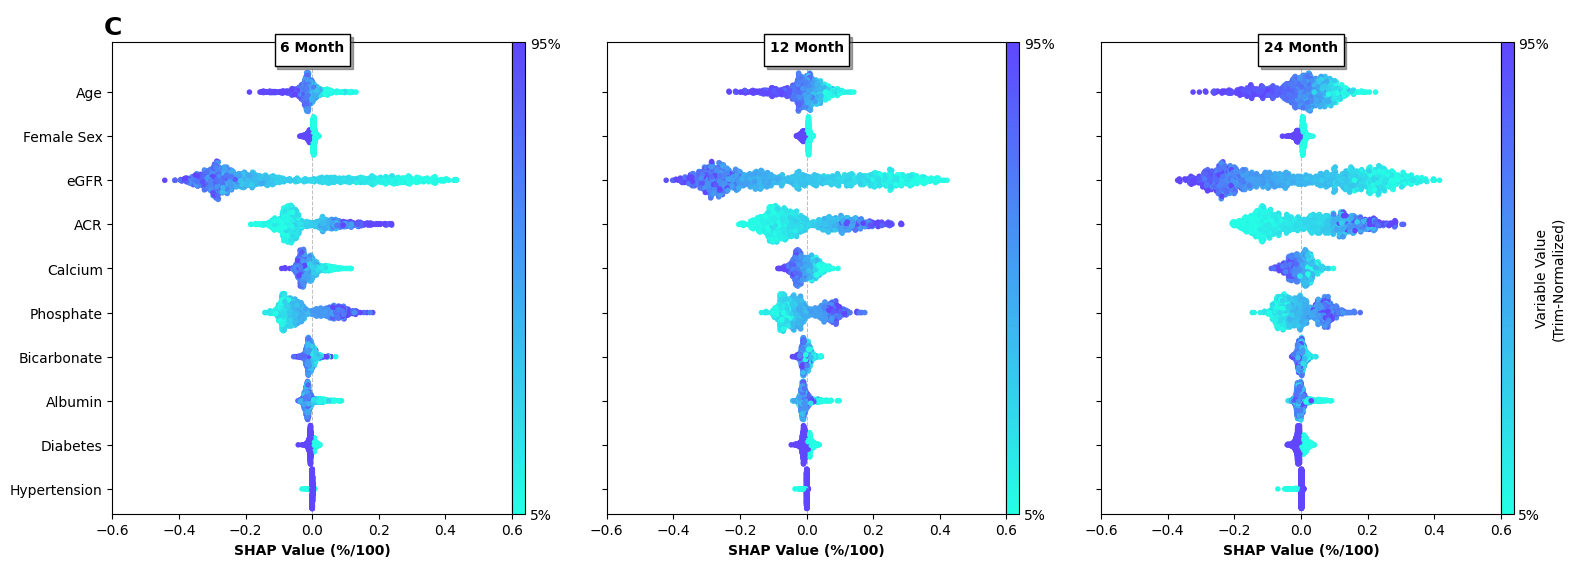

In [481]:
plt.style.use("default")
fig_height = 5.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]
        

for rfci, (rfc, explainer, shap_values) in enumerate(tens):
    num_feats = shap_values[1].shape[1]

    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-7.65)

    plots[rfci].vlines(
        x=[0], ymin=-7.65, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.032),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.085), title="C", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=20 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)
plt.tight_layout()
plt.show()

**13V**

In [432]:
%autoreload

thirteens = list()

for rfci, rfc in enumerate(rfc_shap_values):

    rfc = rfc[3]

    explainer = shap.TreeExplainer(rfc[0])
    shap_values = explainer.shap_values(rfc[1])

    thirteens.append([rfc, explainer, shap_values])

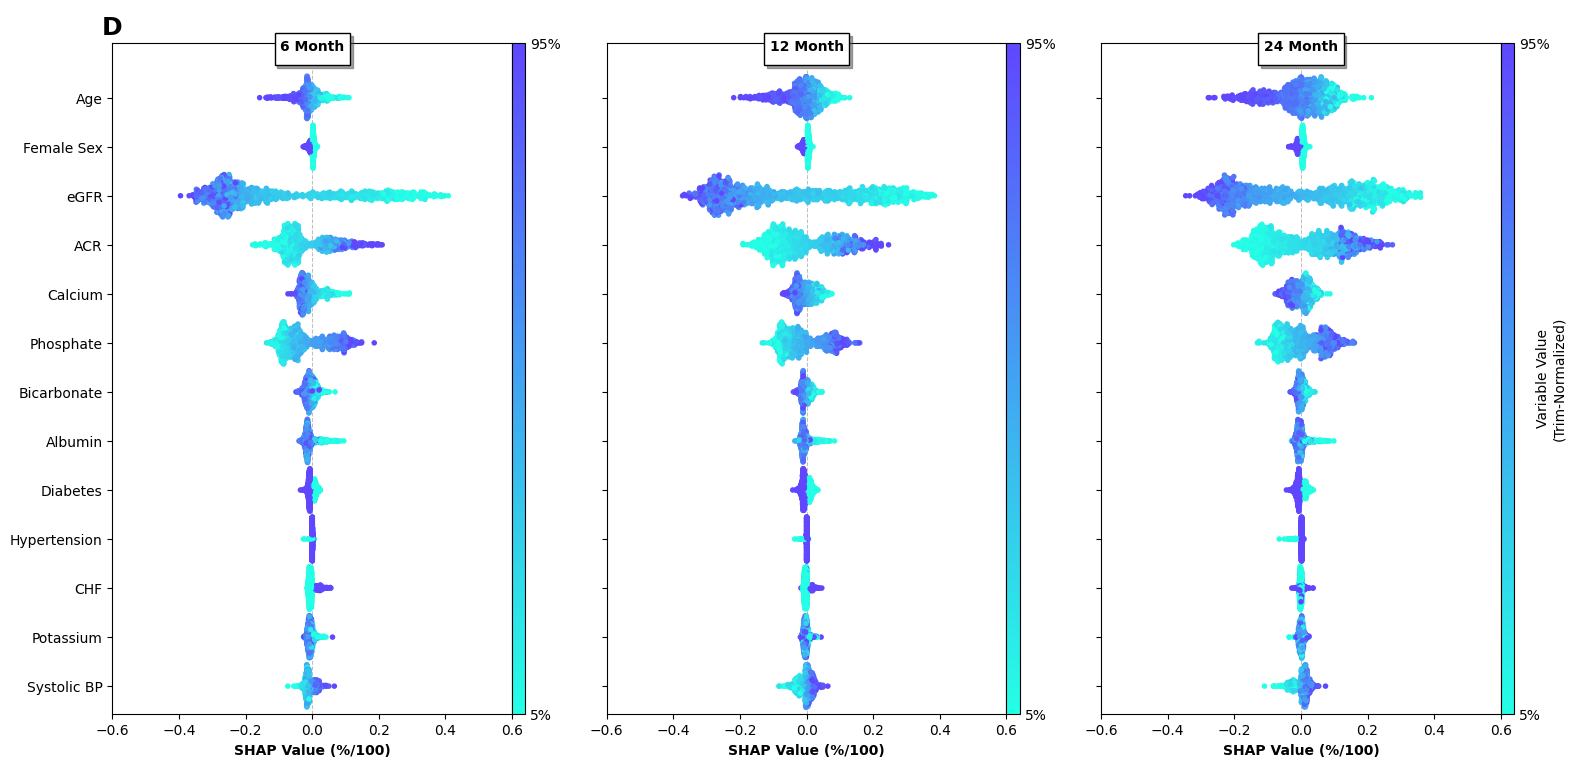

In [508]:
plt.style.use("default")
fig_height = 7.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
months = ["6 Month", "12 Month", "24 Month"]

for rfci, (rfc, explainer, shap_values) in enumerate(thirteens):

    num_feats = shap_values[1].shape[1]
    
    for i in range(num_feats):

        feature_name = rfc[1].columns[i]

        # baseline (expected prediction) 
        bl = explainer.expected_value[1]

        # for treeexplainer
        d = shap_values[1][:,i]

        plib.my_shap_swarmplot(
            d, bl, rfc[1][feature_name].to_numpy(), defs.col_pretty_map[feature_name], feature_name in defs.cat_vars, my_cmap,
            pos=np.argwhere(np.asarray(var_id_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-0.6, 0.6), xlabel="SHAP Value (%/100)"
        )
        
    plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
    plots[rfci].set_ylim(top=0.9, bottom=-10.05)

    plots[rfci].vlines(
        x=[0], ymin=-10.05, ymax=0.45, linestyles="dashed",
        color="black", **{"alpha":0.25, "linewidth":0.75}
    )

    leg = Legend(
        plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0.5, 1.024),
        ncol=2, fancybox=False, shadow=True, framealpha=1, columnspacing=0.8, handletextpad=0.5, 
        edgecolor="black",
        title="{}".format(months[rfci]), 
        title_fontproperties=dict(weight="bold")
    )
    plots[rfci].add_artist(leg)

    # will have to cut and paste the panel labels in
    if rfci == 0:
        leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.06), title="D", title_fontproperties=dict(weight="bold", size="18"), 
                    ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
        plots[rfci].add_artist(leg2)

    # only color bar on 24-monthers
    # going to splice these figures together
    m = cm.ScalarMappable(cmap=my_cmap)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=20 * (fig_height / 3))
    cb.set_ticklabels(["5%", "95%"])
    cb.ax.tick_params(length=0)
    cb.set_alpha(1)

    if rfci == 2:
        cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)
plt.tight_layout()
plt.show()

## Random Survival Forest

In [438]:
rsf_shap_values = list()

for dfk in dfs_dict.keys():
    temp_rsf_shap_values = list()

    for vi, var_set in enumerate(vs):
        dft = dfs_dict[dfk][0].copy()

        rsf = RandomSurvivalForest(
            max_depth=16, min_samples_leaf=8, min_samples_split=4, oob_score=True, n_estimators=500, n_jobs=-1
        )
        print("Fitting...", end=""), 
        # make format for sksurv (list of tuples: (censor, sa_time))
        inds_rsf = dft.drop_duplicates(subset="pt_id", keep="first").reset_index(drop=True)
        x_rsf = inds_rsf[var_set].rename(columns=defs.col_pretty_map).copy()
        y_rsf = format_for_sksurv(inds_rsf[["censor", "sa_time"]])

        rsf.fit(x_rsf, y_rsf)

        print("Fitted")
        temp_rsf_shap_values.append((
            rsf, dft[var_set].iloc[sample_is].rename(columns=defs.col_pretty_map), 
            dft.label.iloc[sample_is]
        ))
    
    rsf_shap_values.append(temp_rsf_shap_values)

Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted
Fitting...Fitted


### Figure S2

**4V Risk Score**

In [485]:
rsf4 = rsf_shap_values[0][0]

explainer4 = shap.Explainer(rsf4[0].predict, rsf4[1].iloc[:100])
shap_values4 = explainer4(rsf4[1].iloc[:100])

Exact explainer: 101it [02:35,  1.65s/it]                         


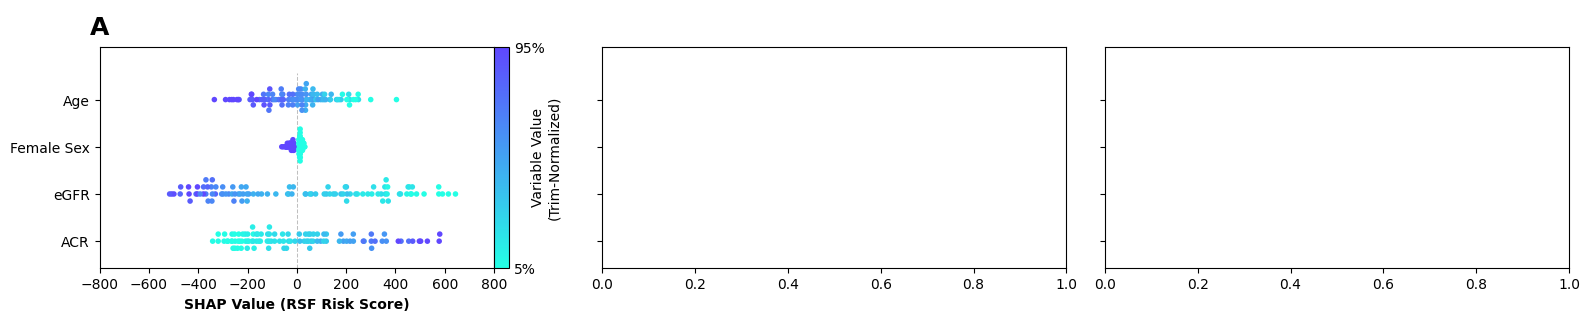

In [523]:
plt.style.use("default")
fig_height = 3

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
rfci = 0

num_feats = shap_values4.values.shape[1]

for i in range(num_feats):

    feature_name = rsf4[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values4.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf4[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(np.asarray(var_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-2.85)

plots[rfci].vlines(
    x=[0], ymin=-2.85, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

# will have to cut and paste the panel labels in
if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.2), title="A", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=15 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**8V Risk Score**

In [439]:
rsf8 = rsf_shap_values[0][1]

explainer8 = shap.Explainer(rsf8[0].predict, rsf8[1].iloc[:100])
shap_values8 = explainer8(rsf8[1].iloc[:100])

Exact explainer: 101it [37:25, 22.46s/it]                         


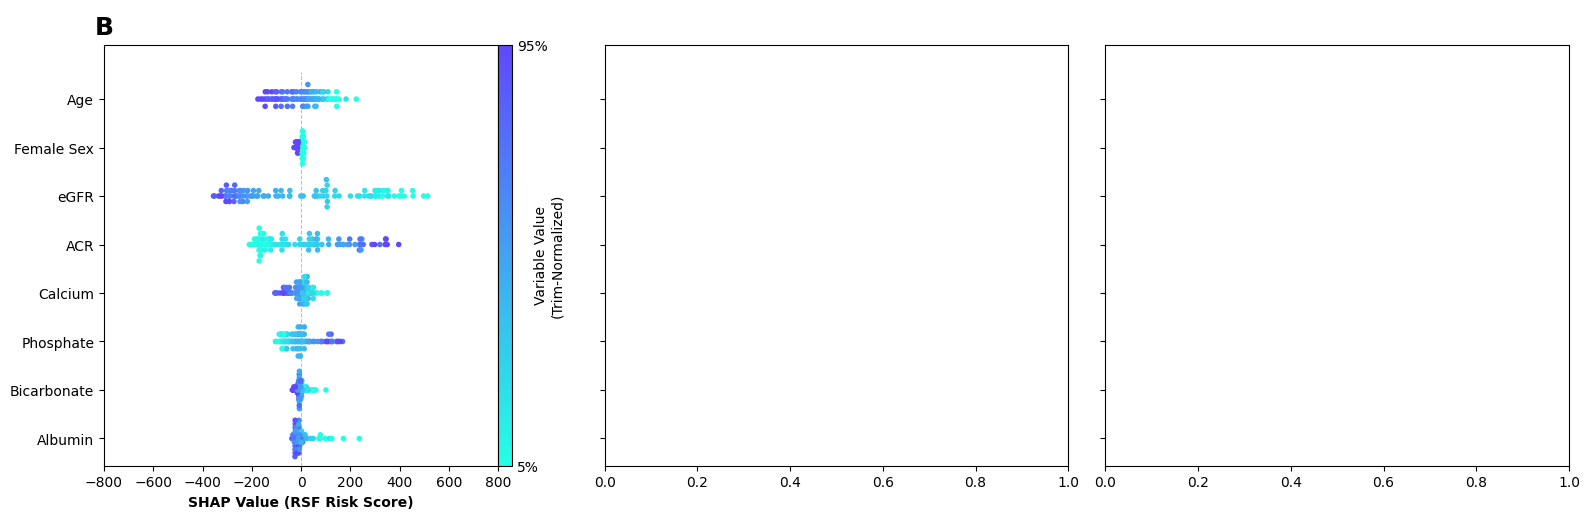

In [525]:
plt.style.use("default")
fig_height = 5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)

panel_letters = ["A", "B", "C"]
rfci = 0

num_feats = shap_values8.values.shape[1]

for i in range(num_feats):

    feature_name = rsf8[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values8.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf8[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(np.asarray(var_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-6.05)

plots[rfci].vlines(
    x=[0], ymin=-6.05, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

# will have to cut and paste the panel labels in
if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.1), title="B", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**10V Risk Score**

In [494]:
rsf10 = rsf_shap_values[0][2]

explainer10 = shap.Explainer(rsf10[0].predict, rsf10[1].iloc[:100])
shap_values10 = explainer10(rsf10[1].iloc[:100])

Exact explainer: 101it [2:52:21, 103.42s/it]                          


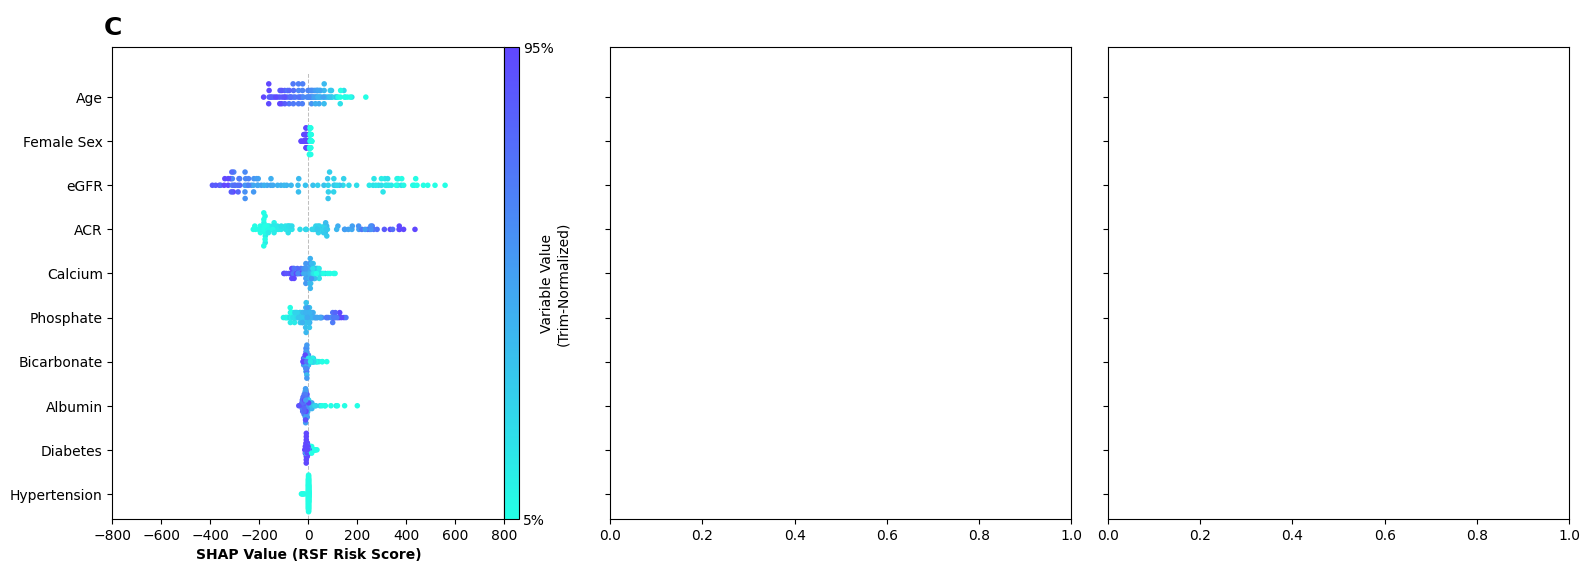

In [526]:
plt.style.use("default")
fig_height = 5.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)

panel_letters = ["A", "B", "C"]
months = ["6 Month", "12 Month", "24 Month"]
rfci = 0

num_feats = shap_values10.values.shape[1]

for i in range(num_feats):

    feature_name = rsf10[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values10.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf10[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(np.asarray(var_order) == feature_name)[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-7.65)

plots[rfci].vlines(
    x=[0], ymin=-7.65, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.095), title="C", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()

**13V Risk Score**

In [495]:
rsf13 = rsf_shap_values[0][3]

explainer13 = shap.Explainer(rsf13[0].predict, rsf13[1].iloc[:100])
shap_values13 = explainer13(rsf13[1].iloc[:100])

Permutation explainer: 101it [1:19:55, 47.95s/it]                         


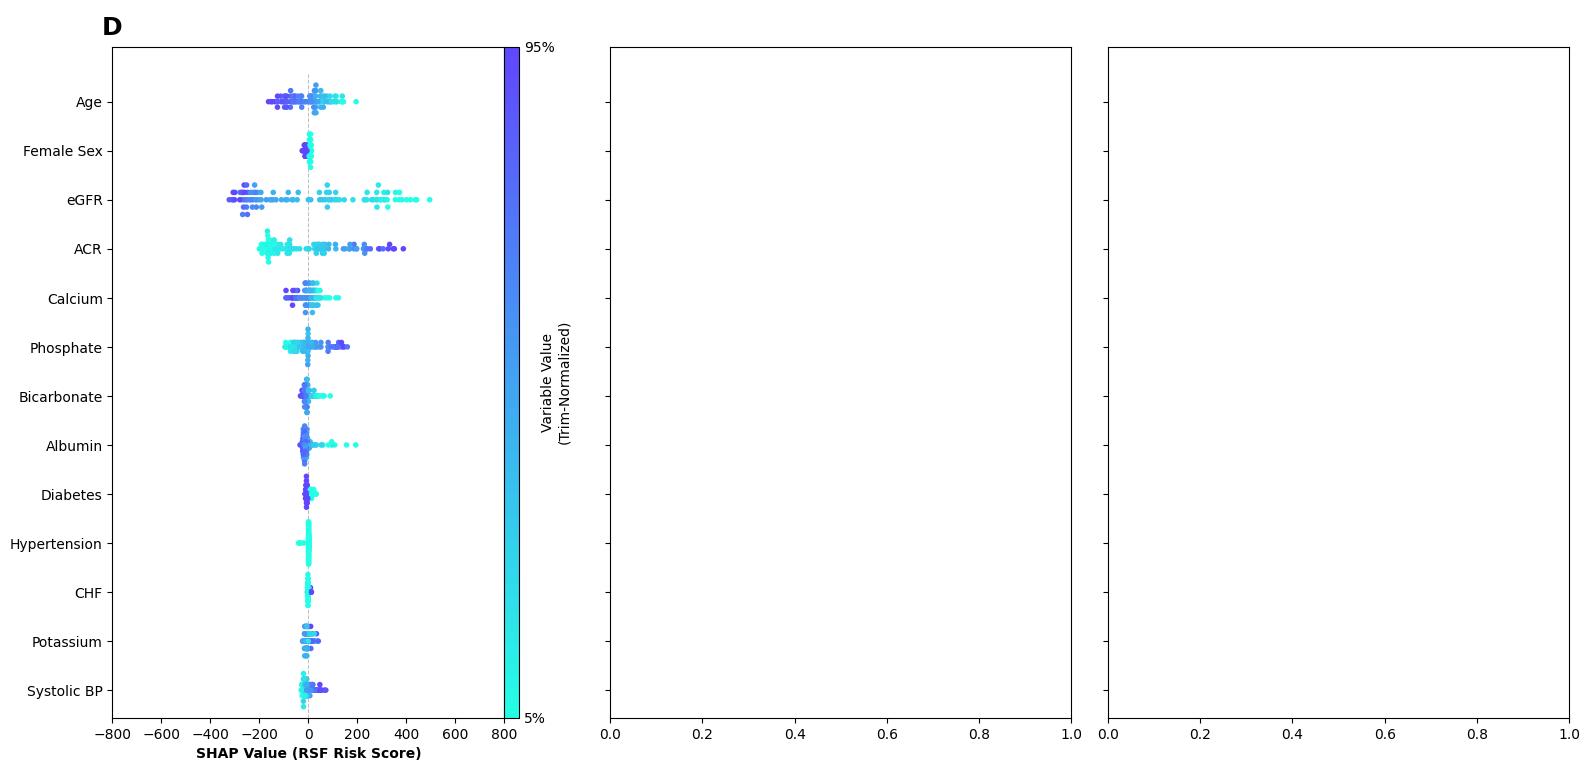

In [527]:
plt.style.use("default")
fig_height = 7.5

fig, plots = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(16, fig_height)
rfci = 0

num_feats = shap_values13.values.shape[1]

for i in range(num_feats):

    feature_name = rsf13[1].columns[i]

    # baseline (expected prediction) 
    bl = 0

    # for treeexplainer
    d = shap_values13.values[:,i]

    plib.my_shap_swarmplot(
        d, bl, rsf13[1][feature_name].to_numpy(), feature_name, feature_name in defs.cat_vars, my_cmap,
        pos=np.argwhere(
            np.asarray(var_order) == ("CHF" if feature_name == "Congestive Heart Failure" else feature_name)
        )[0][0], ax=plots[rfci], row_height=0.4, xlims=(-800, 800), xlabel="SHAP Value (RSF Risk Score)"
    )
    
plots[rfci].set_yticks([(-i * 0.4 * 2) for i in range(num_feats)], var_order[:num_feats])
plots[rfci].set_ylim(top=0.9, bottom=-10.05)

plots[rfci].vlines(
    x=[0], ymin=-10.05, ymax=0.45, linestyles="dashed",
    color="black", **{"alpha":0.25, "linewidth":0.75}
)

# will have to cut and paste the panel labels in
if rfci == 0:
    leg2 = Legend(plots[rfci], [], [], loc="upper center", bbox_to_anchor=(0, 1.065), title="D", title_fontproperties=dict(weight="bold", size="18"), 
                ncol=1, fancybox=False, shadow=False, framealpha=0, columnspacing=0.8, borderpad=0.4, handletextpad=0.1, edgecolor="black")
    plots[rfci].add_artist(leg2)

# only color bar on 24-monthers
# going to splice these figures together
m = cm.ScalarMappable(cmap=my_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], ax=plots[rfci], pad=0, aspect=18 * (fig_height / 3))
cb.set_ticklabels(["5%", "95%"])
cb.ax.tick_params(length=0)
cb.set_alpha(1)

if rfci == 0:
    cb.set_label("Variable Value\n(Trim-Normalized)", labelpad=-10)

plt.tight_layout()
plt.show()